In [1]:
# imports
from inspect import signature

import scipy
import psopy
import gamod
import tsmod
import sysid
import ssid

from ipywidgets import interact, interactive, interact_manual
from IPython.display import display
import IPython.display as dis
import ipywidgets as wid

import time
import os.path

import random
import pandas
import numpy
import control
from matplotlib import pyplot as plt

In [2]:
# inputs
def step(t, start, stop):
    if t<start:
        return 0
    else:
        return 1

def rect(t, start, drop, stop):
    if t>=start and t<stop:
        return 1
    else:
        return 0

def doublet(t, start, drop, rise, stop):
    if t>=start and t<drop:
        return 1
    elif t>=drop and t<rise:
        return -1
    else:
        return 0
    
input_dict = {'Step': step, 
              'Rect': rect, 
              'Doublet': doublet}

In [3]:
# read data
def load_data(file):
    if file == '':
        print('Please enter a file name to load.')
        return [0, 0, 0]
    else:
        df = pandas.read_csv(f'{file}.csv')
        ydata = df['Y'] - df['Y'][0]
        udata = df['U'] - df['U'][0]
        tdata = df['Time']
        return [ydata, udata, tdata]

# save data
def save_data(d, save_name):
    t, y, u, yr, dur, coeff, div = d
    
    dd = {'Time': t,
          'Y': y,
          'U': u,
          'Y Estimate': yr}
    
    df = pandas.DataFrame(data=dd)
    
    if save_name == '':
        save_name = 'New_Save'
    
    while os.path.isfile(f'{save_name}.csv'):
        save_name = save_name + "(1)"
    
    df.to_csv(f'{save_name}.csv')
    
    dr = {'Run Time (s)': dur}
    
    for i in range(len(coeff)):
        if i < div:
            dr[f'Numerator {i}'] = [coeff[i]]
        else:
            dr[f'Denominator {i-div}'] = [coeff[i]]
            
    dfr = pandas.DataFrame(data=dr)
    dfr.to_csv(f'{save_name}_results.csv')
    
    return print(f'{save_name} successfully saved.')

In [4]:
#  noise

def uniform_noise(ydata, Magnitude): #currently does not include 1
    return [ydata[i] + random.uniform(-1,1)*Magnitude for i in range(len(ydata))]

def pseudo_noise(ydata, Magnitude): #currently only returns int values
    return [ydata[i] + random.randrange(start=-1,stop=1)*Magnitude for i in range(len(ydata))]

def no_noise(ydata):
    return ydata

noise_dict = {'None': no_noise,
              'Uniform': uniform_noise,
              'Non-uniform': pseudo_noise}

In [5]:
# system
def create_system(Numerator, Denominator):
    return control.tf(Numerator, Denominator)

(array([0.36787944, 0.26424112]), array([ 1.        , -0.36787944]))

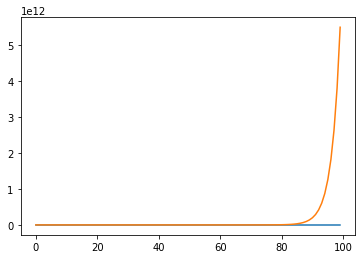

In [12]:
# test ssid

ts = range(100)
us = [step(t, 20, 100) for t in ts]
_, ys, _ = control.forced_response(control.tf([1], [1,1]), T=ts, U=us)
plt.plot(ts, ys)

def subspace_id(y, u):
    ts = range(100)
    ss1_id = sysid.subspace_det_algo1(y, u, f=2, p=2, s_tol=1e-2, dt=0.1)
    A, B, C, D = ss1_id.A, ss1_id.B, ss1_id.C, ss1_id.D
    tf = scipy.signal.lti(A, B, C, D).to_tf()
    _, ys, _ = control.forced_response(control.tf(tf.num, tf.den), T=ts, U=us)
    plt.plot(ts, ys) 
    return tf.num, tf.den

subspace_id(ys, us)

In [134]:
# Techniques 

def subspace_id(y, u):
    ss1_id = sysid.subspace_det_algo1(y, u, f=5, p=5, s_tol=1e-1, dt=1)
    return ss1_id 

def DE(function, Bounds):
    return scipy.optimize.differential_evolution(function, Bounds).x

def LS(function, Initial_Guess):
    return scipy.optimize.least_squares(function, [i[0] for i in Initial_Guess]).x

def MIN(function, Initial_Guess):
    return scipy.optimize.minimize(function, [i[0] for i in Initial_Guess]).x

def PSO(function, Initial_Bounds):
    return psopy.minimize(function, numpy.array([numpy.random.uniform(*b, 10) for b in Initial_Bounds]).T).x

def GA(function, Lengths):
    print(Lengths)
    return gamod.genetic_algorithm(function, [int(i[0]) for i in Lengths])

def TS(function, Bounds):
    return tsmod.tabu_search(function, Bounds)

# def SSID(function, ):
#     return
    
tech_dict = {'Differential Evolution': DE,
            'Least Squares': LS,
            'Scipy Minimize': MIN,
            'Particle Swarm': PSO,
            'Genetic Algorithm': GA,
            'Tabu Search': TS}

# any other technique can be added here as long as the signature is in the form [function, parameters] - the function has to be added to the dictionary manually with the appropriate name.

In [135]:
# Misc

def err(params, ts, ym, us, div):
    num = params[:div]
    den = params[div:]
    est_sys = control.tf(num, den)
    tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
    return sum((ym - ysim)**2)

def res(params, ts, ym, us, div):
    num = params[:div]
    den = params[div:]
    est_sys = control.tf(num, den)
    tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
    plt.plot(tsim, ysim, '--', label="Estimation")
    return ysim

In [136]:
def sim(Input='Step', Noise="None", Technique='Tabu Search'):

    Load_Name = wid.Text(value='', description='Load Name', disabled=False)
    run_load = wid.Button(description="Load", disabled=False)
    load_state = False
    
    def run_load_clicked(b):
        with output:
            dis.clear_output(True)
            global ts, ym, us
            ydata, udata, tdata = load_data(Load_Name.value)
            ts, ym, us = tdata, ydata, udata
            global load_state
            load_state = True
            
            plt.plot(ts, ym, label="Loaded")
            plt.legend()
            plt.show()
            
    run_load.on_click(run_load_clicked)
    
    u = input_dict[Input]
    u_sig = u.__code__.co_varnames[1:]
    c_input_params = {}
    c_input_wid = {}
    for var in u_sig:
        
        c_input_wid[var] = wid.IntSlider(value=1, min=0, max=600, description=var, disabled=False)
        display(c_input_wid[var])
        
    n = noise_dict[Noise]
    n_sig = n.__code__.co_varnames[1:]
    c_noise_params = {}
    c_noise_wid = {}
    for var in n_sig:
        c_noise_wid[var] = wid.FloatSlider(value=0, min=0, max=0.5, step=0.01, description=var, disabled=False)
        display(c_noise_wid[var])
    
    sys = create_system
    sys_sig = sys.__code__.co_varnames
    c_sys_params = {}
    c_sys_wid = {}
    for var in sys_sig:
        c_sys_wid[var] = wid.Text(value='1', description=var, disabled=False)
        display(c_sys_wid[var])
        
    tech = tech_dict[Technique]
    tech_sig = tech.__code__.co_varnames[1:]
    for names in tech_sig:
        display(names+"(inputs separated by a semicolon):")
    
    c_tech_wid = {}
    for var1 in tech_sig:
        for var2 in sys_sig:
            var = str(var1) + str(var2)
            c_tech_wid[var] = wid.Text(value='1', description=var2, disabled=False)
            display(c_tech_wid[var])
    
    Save_Name = wid.Text(value='', description='Save Name', disabled=False)
    display(Save_Name)
    display(Load_Name)
    
    run_sim = wid.Button(description='Simulate')
    run_est = wid.Button(description='Estimate')
    
    run_state = False
    
    output = wid.Output()

    def run_sim_clicked(b):
        with output:
            dis.clear_output(True)
            global ts, ym, us
            
            for var in u_sig:
                c_input_params[var] = c_input_wid[var].value
                
            for var in n_sig:
                c_noise_params[var] = c_noise_wid[var].value
            
            for var in sys_sig:
                c_sys_params[var] = [float(i) for i in c_sys_wid[var].value.split(';')]
            
            ts = numpy.linspace(0, c_input_params['stop'], c_input_params['stop']*1)
            us = [u(t, *c_input_params.values()) for t in ts]
            
            system = create_system(*c_sys_params.values()) 
            print(system)
            tm, y1, xm = control.forced_response(system, T=ts, U=us)
            
            ym = n(y1, *c_noise_params.values())
            
            plt.plot(tm, ym, label="Real")
            plt.legend()            
            plt.show()
        
    def run_est_clicked(b):
        with output:
            dis.clear_output(True)
            arr_tech_params = []
            orders = []
            
            for o, var in enumerate(c_tech_wid):
                orders.append(len(c_tech_wid[var].value.split(';')))
                for k in range(orders[o]):
                    arr_tech_params.append([float(j) for j in [i.split(',') for i in c_tech_wid[var].value.split(';')][k]]) 
            
            div = orders[0]
            
            def err_wrap(params):
                return err(params, ts, ym, us, div)
        
            def res_wrap(params):
                return res(params, ts, ym, us, div)
            
            print('Running...')
            st = time.time()
            coeff = tech(err_wrap, arr_tech_params)
            et = time.time()
            print('Done.')
            
            dur = et-st
            print("Parameters estimated as {} in {} seconds".format(coeff, dur))
            
            plt.plot(ts, ym, label="Real/Loaded")
            yres = res_wrap(coeff)
            
            global d
            d = ts, ym, us, yres, dur, coeff, div
            
            plt.legend()            
            plt.show()
            run_state = True            
    
    display(run_sim)
    display(run_est, output)
    
    run_sim.on_click(run_sim_clicked)
    run_est.on_click(run_est_clicked)
    
    run_save = wid.Button(description="Save", disabled=run_state)
    
    display(run_save)
    display(run_load)
    
    def run_save_clicked(b):
        with output:
            save_data(d, Save_Name.value)
            
    run_save.on_click(run_save_clicked)

In [137]:
interact(sim, 
         Input=[keys for keys, dict in input_dict.items()], 
         Noise=[keys for keys, dict in noise_dict.items()],
         Technique=[keys for keys, dict in tech_dict.items()])

interactive(children=(Dropdown(description='Input', options=('Step', 'Rect', 'Doublet'), value='Step'), Dropdo…

<function __main__.sim(Input='Step', Noise='None', Technique='Tabu Search')>

In [10]:
class Test:
    
    def __init__(self):
        self.methods = []

    def func1(a):
        return print(f'is this working? {a}')

    def func2():
        return "func2"

    l = locals()
    
    def method_list(self):
        for f in dir(self):
            if callable(getattr(self, f)) and not f.startswith("_") and f != "method_list":
                self.methods.append(f)   
        funcs = [self.l[f] for f in self.methods]
        
        return funcs


In [11]:
t = Test()
t.method_list()[0]('yes')

is this working? yes


In [34]:
class Test:
    
    def __init__(self):
        return None

    def func1(a):
        return print(a)

    def func2(a, b):
        return print(f'first variable = {a}, second variable = {b}')

    l = locals()
    
def method_list(obj):
    methods = []
    for f in dir(obj):
        if callable(getattr(obj, f)) and not f.startswith("_"):
            methods.append(f)   
    funcs = [obj.l[f] for f in methods]
    vars = [f.__code__.co_varnames for f in funcs]
    return list(zip(funcs, vars))

t = Test()
method_list(t)[1][0](*[a for a in method_list(t)[1][1]])

first variable = a, second variable = b
